In [1]:
from netCDF4 import Dataset 
import xarray as xr
import numpy as np
from eofs.xarray import Eof
import matplotlib as mpl
import matplotlib.pyplot as plt

gec_npth='E:/_data/GECCO/GECCO_TEMP_194801_201812.nc'

In [2]:
lat_rng,lon_rng=[-80,-20],[120,290]
Stemp=xr.open_dataset(gec_npth).temp.loc[dict(lat=slice(lat_rng[0],lat_rng[-1]),lon=slice(lon_rng[0],lon_rng[-1]),time=slice('1980-01','2018-12'),Depth=6)]

In [3]:
### Lou et al 2019 method ====================================
# Remove Linear trend
NC=Stemp.assign_coords({'TT':('time',range(len(Stemp.time)))})
NC=NC.swap_dims({"time":"TT"})
NC_s=NC.polyfit(dim='TT',deg=1,skipna=True)
fit = xr.polyval(NC.TT, NC_s.polyfit_coefficients)
Coef=NC_s.polyfit_coefficients[0]
Coef_var=Coef.values*12 # (m/year)
data_dt=NC-fit
data_dt=data_dt.swap_dims({"TT":"time"})

# Remove seasolnal mean 
Monthly_avg=data_dt.groupby('time.month').mean().values
T,L,M=NC.shape
Monthly_avg_=np.zeros([int(T),L,M])
for i in range(int(T/12)):
    Monthly_avg_[12*i:12*(i+1)]=Monthly_avg
Monthly_avg=Monthly_avg_


In [4]:
ds = xr.Dataset(
    data_vars=dict(
        mon_temp=(["time", "lat", "lon"], Monthly_avg),),
    coords=dict(
        lon=("lon", Stemp.lon.values),
        lat=("lat", Stemp.lat.values),
        time=Stemp.time.values,
        # reference_time=Stemp.time.units,
        ),
    attrs=dict(description="Weather related data."),)

In [5]:
A=data_dt-ds.mon_temp  
# A.mean(dim=['lat','lon']).plot()
# Stemp.mean(dim=['lat','lon']).plot()

In [6]:
data_dt_1Y=data_dt.rolling(time=12,center=True).mean().mean(dim=['lon','lat'])
data_dt_1Y=data_dt.rolling(time=12,center=True).mean()[6:-6]

In [17]:
A=A.reset_coords(drop=True)

In [18]:
NN=10
solver=Eof(A)
eofs = -solver.eofs(neofs=NN, eofscaling=0)
pcs = -solver.pcs(npcs=NN,pcscaling=0)

var_=solver.varianceFraction(NN)
var=var_/np.sum(var_)*100

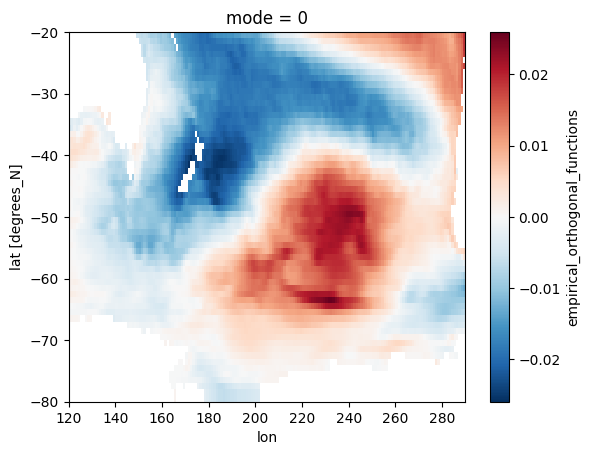

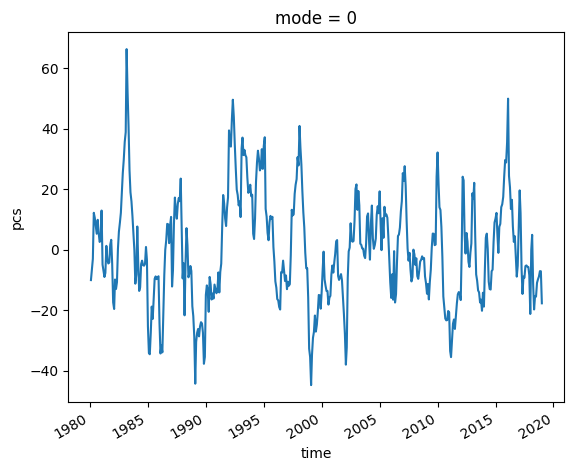

In [24]:
plt.figure(1)
eofs[0].plot()
plt.figure(2)
pcs[:,0].plot()

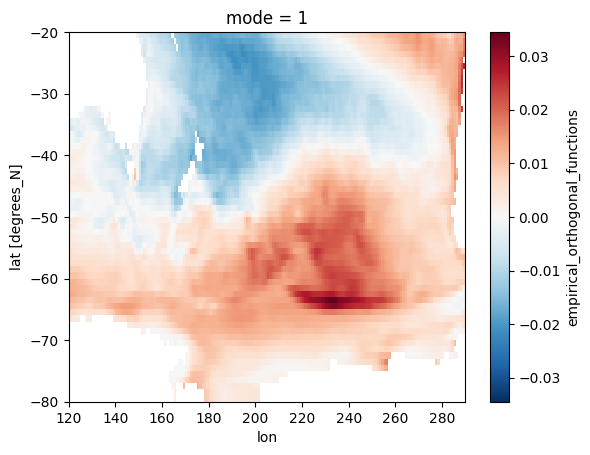

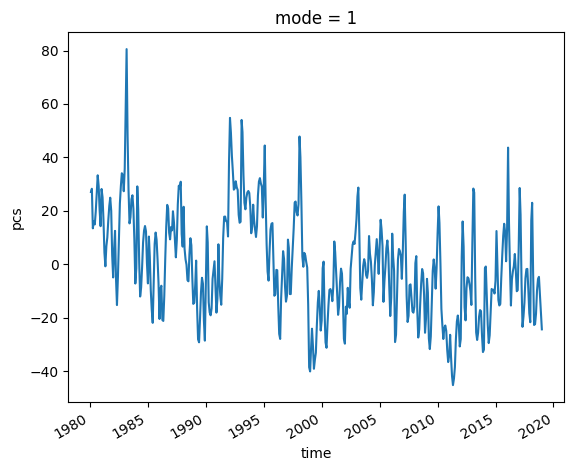

In [9]:
plt.figure(1)
eofs[1].plot()
plt.figure(2)
pcs[:,1].plot()